# Авиарейсы без потерь, анализ прибыльности рейсов

##### Для анализа будем использовать простую модель: прибыль = стоимость билетов на рейс - затраты на топливо на рейс

##### Для расчета затрат на топливо воспользуемся такими показателями используемых самолетов как часовой расход топлива. Таким образом, затраты на топливо на рейс = длительность полета в часах * часовой расход топлива в кг/ч * стоимость топлива в рублях за тонну топлива /1000


### Импорт библиотек

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (12,8)

### импорт данных, использовались следующие запросы для получения CSV из Metabase:

In [172]:
# flights:
SELECT *
FROM dst_project.flights F
join dst_project.ticket_flights TF on F.flight_id = TF.flight_id
WHERE departure_airport = 'AAQ'
  AND (date_trunc('month', scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
  AND status not in ('Cancelled')

# aircrafts
SELECT *
FROM dst_project.aircrafts

# airports
SELECT *
FROM dst_project.airports

# mean_tickets_count
with A as(
SELECT F.flight_id, F.aircraft_code, TF.fare_conditions, AP.city, count(TF.ticket_no) tickets_count
FROM dst_project.flights F
join dst_project.ticket_flights TF on F.flight_id = TF.flight_id
join dst_project.airports AP on AP.airport_code = F.arrival_airport
WHERE departure_airport = 'AAQ'
  AND (date_trunc('month', scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
  AND status not in ('Cancelled')
Group by 1,2,3,4
)
select A.aircraft_code,A.fare_conditions,A.city, avg(tickets_count)
from A 
group by 1,2,3

# max_tickets_count
SELECT AC.aircraft_code,
       S.fare_conditions,
       Count(*)
FROM dst_project.aircrafts AC
JOIN dst_project.seats S ON S.aircraft_code = AC.aircraft_code
WHERE AC.aircraft_code in ('733',
                           'SU9')
GROUP BY AC.aircraft_code,
         S.fare_conditions

# tickets_cost
SELECT F.aircraft_code,
       TF.fare_conditions,
       AP.city,
       TF.amount
FROM dst_project.flights F
JOIN dst_project.ticket_flights TF ON F.flight_id = TF.flight_id
JOIN dst_project.airports AP ON AP.airport_code = F.arrival_airport
WHERE departure_airport = 'AAQ'
  AND (date_trunc('month', scheduled_departure) in ('2017-01-01',
                                                    '2017-02-01',
                                                    '2017-12-01'))
  AND status not in ('Cancelled')
GROUP BY 1,
         2,
         3,
         4

SyntaxError: invalid syntax (<ipython-input-172-23db95b74fd9>, line 2)

##### Импорт данных

In [173]:
# датасет с рейсами
flights = pd.read_csv('Flights_with_tickets.csv')

# датасет с самолетами
aircrafts = pd.read_csv('AirCrafts.csv')

# датасет с аэропортами
airports = pd.read_csv('AirPorts.csv')

# датасет с инф-ией о среднем кол-ве билетов в каждом классе, в каждом направлении
mean_tickets_count = pd.read_csv('mean_tickets_count.csv')

# датасет с инф-ией о максимально возможном кол-ве билетов в каждом классе, в каждом направлении
max_tickets_count = pd.read_csv('max_tickets_count.csv')

# датасет с инф-ией о стоимости билетов разных классов, в разных самолетах, по разным направлениям
tickets_cost = pd.read_csv('tickets_cost.csv')



##### дополнительные данные

In [174]:
# цена тонны авиационного керосина взята как медиана из цен представленных на сайте: 
# https://oilresurs.ru/catalog/aviacionnyj-kerosin/
Arr = [59500,52100,60000,61900,60800,62200,63500]
Fuel_cost = np.median(Arr)
Fuel_cost

60800.0

In [175]:
# расход топлива рахных самолетов взят с сайта 
# https://vpolete.online/pereletyi/rashod-topliva-raznyih-samoletov.html
# consumtion приводится в кг/ч
Fuel = pd.DataFrame({'aircraft_code':['733','SU9'], 'consumption':[2400,1700]})

Fuel

,aircraft_code,consumption
0,733,2400
1,SU9,1700


##### Предобработка данных

In [176]:
# Убираем лишние колонки
flights.drop(['scheduled_departure', 'scheduled_arrival'], axis=1, inplace=True)

# чтобы соединить по коду самолета flights и aircrafts
flights.rename(columns={'arrival_airport': 'airport_code'}, inplace=True)

# перевод действительного времени отправления и прилета в datetime:
flights.actual_departure = pd.to_datetime(flights.actual_departure , format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
flights.actual_arrival = pd.to_datetime(flights.actual_arrival , format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

# вычисление кол-ва часов в полете
flights['flight_hours'] = abs(flights.actual_arrival - flights.actual_departure).apply(lambda x: x.seconds/3600).fillna(1)


##### Соединение в один датасет

In [177]:
DF = flights.merge(aircrafts, on='aircraft_code', how='left') \
            .merge(airports,  on='airport_code',  how='left') \
            .merge(Fuel,      on='aircraft_code', how='left')
DF.sample(5)         

,flight_id,flight_no,departure_airport,airport_code,status,aircraft_code,actual_departure,actual_arrival,ticket_no,flight_id_2,...,amount,flight_hours,model,range,airport_name,city,longitude,latitude,timezone,consumption
1464,136729,PG0480,AAQ,EGO,Arrived,SU9,2017-01-29 09:29:00,2017-01-29 10:19:00,5432375480,136729,...,6300.0,0.833333,Sukhoi Superjet-100,3000,Belgorod International Airport,Belgorod,36.590099,50.643799,Europe/Moscow,1700
5962,136275,PG0252,AAQ,SVO,Arrived,733,2017-01-13 10:08:00,2017-01-13 11:46:00,5435171443,136275,...,13400.0,1.633333,Boeing 737-300,4200,Sheremetyevo International Airport,Moscow,37.414600,55.972599,Europe/Moscow,2400
677,136669,PG0480,AAQ,EGO,Arrived,SU9,2017-01-17 09:26:00,2017-01-17 10:17:00,5432375065,136669,...,6300.0,0.850000,Sukhoi Superjet-100,3000,Belgorod International Airport,Belgorod,36.590099,50.643799,Europe/Moscow,1700
1095,136660,PG0480,AAQ,EGO,Arrived,SU9,2017-02-20 09:26:00,2017-02-20 10:15:00,5432320556,136660,...,6300.0,0.816667,Sukhoi Superjet-100,3000,Belgorod International Airport,Belgorod,36.590099,50.643799,Europe/Moscow,1700
7962,136284,PG0252,AAQ,SVO,Arrived,733,2017-02-07 10:07:00,2017-02-07 11:48:00,5435172130,136284,...,12200.0,1.683333,Boeing 737-300,4200,Sheremetyevo International Airport,Moscow,37.414600,55.972599,Europe/Moscow,2400


##### Вычисление стоимости горючего за рейс и прибыли

In [178]:
# сделаем отдельный датасет, содержащий id рейса и суммарную стоимость билетов
revenue = pd.DataFrame(DF.groupby(DF.flight_id).amount.sum())

# и сделаем отдельный датасет, содержащий всю инф-ю для вычисления затрат на топливо на рейс:
expense = DF[['flight_id','aircraft_code','city','flight_hours','consumption']].drop_duplicates()

# соединим датасеты по flight_id
DFF = expense.merge(revenue, on='flight_id', how='left')

# вычислим затраты на топливо на рейс
DFF['cost'] = DFF.flight_hours * DF.consumption * Fuel_cost / 1000

# вычислим прибыль как разницу стоимости билетов и затрат на топливо
DFF['profit'] = DFF.amount - DFF.cost
DFF

,flight_id,aircraft_code,city,flight_hours,consumption,amount,cost,profit
0,136936,SU9,Belgorod,0.833333,1700,632400.0,86133.333333,5.462667e+05
1,136632,SU9,Belgorod,0.850000,1700,714300.0,87856.000000,6.264440e+05
2,136855,SU9,Belgorod,0.833333,1700,702300.0,86133.333333,6.161667e+05
3,136706,SU9,Belgorod,0.833333,1700,740100.0,86133.333333,6.539667e+05
4,136571,SU9,Belgorod,0.833333,1700,752700.0,86133.333333,6.665667e+05
...,...,...,...,...,...,...,...,...
113,136185,733,Moscow,1.716667,2400,1520000.0,177434.666667,1.342565e+06
114,136351,733,Moscow,1.666667,2400,1555400.0,172266.666667,1.383133e+06
115,136204,733,Moscow,1.666667,2400,1457800.0,172266.666667,1.285533e+06
116,136428,733,Moscow,1.650000,2400,1678600.0,170544.000000,1.508056e+06


array([<AxesSubplot:title={'center':'Общая сумма билетов'}, xlabel='city'>,
       <AxesSubplot:title={'center':'Кол-во билетов'}, xlabel='city'>],
      dtype=object)

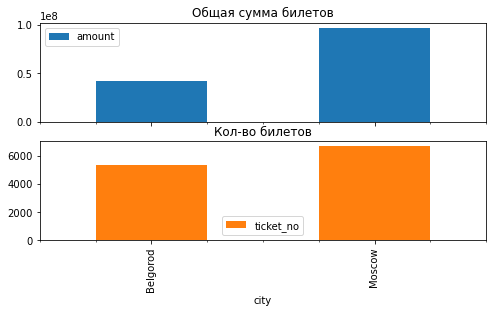

In [179]:
DF.groupby(DF.city).agg({'amount':'sum','ticket_no':'count'}).plot(kind='bar',
                                                                   subplots=True,
                                                                title=['Общая сумма билетов','Кол-во билетов']
                                                                  )


<AxesSubplot:title={'center':'Усредненные затраты на рейс по направлениям'}, xlabel='city'>

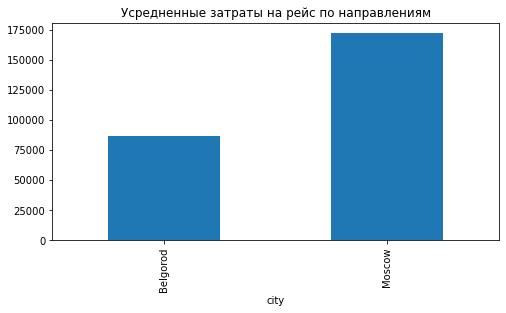

In [180]:
DFF.groupby(DFF.city).cost.mean().plot(kind='bar', title='Усредненные затраты на рейс по направлениям')

<AxesSubplot:title={'center':'Усредненная выручка на рейс по направлениям'}, xlabel='city'>

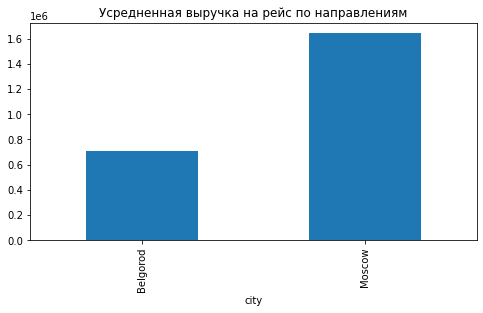

In [182]:
DFF.groupby(DFF.city).amount.mean().plot(kind='bar', title='Усредненная выручка на рейс по направлениям')

<AxesSubplot:title={'center':'Усредненная прибыль на рейс по направлениям'}, xlabel='city'>

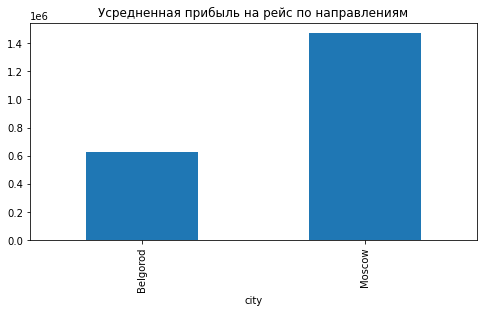

In [183]:
DFF.groupby(DFF.city).profit.mean().plot(kind='bar', title='Усредненная прибыль на рейс по направлениям')

array([<AxesSubplot:title={'center':'Усредненная прибыль на рейс по направлениям'}, xlabel='city'>,
       <AxesSubplot:title={'center':'Усредненная выручка на рейс по направлениям'}, xlabel='city'>,
       <AxesSubplot:title={'center':'Усредненные затраты на рейс по направлениям'}, xlabel='city'>],
      dtype=object)

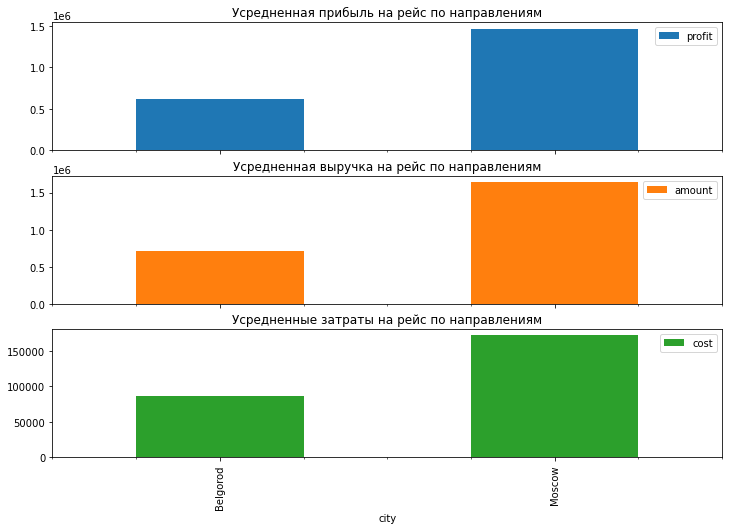

In [189]:
DFF.groupby(DFF.city).agg({'profit':'mean','amount':'mean','cost':'mean'}).plot(kind='bar',
                                                                   subplots=True,
                                                                title=['Усредненная прибыль на рейс по направлениям',
                                                                       'Усредненная выручка на рейс по направлениям',
                                                                       'Усредненные затраты на рейс по направлениям']
                                                                  )

In [163]:
DFF

,flight_id,aircraft_code,city,flight_hours,consumption,amount,cost,profit
0,136936,SU9,Belgorod,0.833333,1700,632400.0,86133.333333,5.462667e+05
1,136632,SU9,Belgorod,0.850000,1700,714300.0,87856.000000,6.264440e+05
2,136855,SU9,Belgorod,0.833333,1700,702300.0,86133.333333,6.161667e+05
3,136706,SU9,Belgorod,0.833333,1700,740100.0,86133.333333,6.539667e+05
4,136571,SU9,Belgorod,0.833333,1700,752700.0,86133.333333,6.665667e+05
...,...,...,...,...,...,...,...,...
113,136185,733,Moscow,1.716667,2400,1520000.0,177434.666667,1.342565e+06
114,136351,733,Moscow,1.666667,2400,1555400.0,172266.666667,1.383133e+06
115,136204,733,Moscow,1.666667,2400,1457800.0,172266.666667,1.285533e+06
116,136428,733,Moscow,1.650000,2400,1678600.0,170544.000000,1.508056e+06


##### Мы оценили среднюю прибыль по обоим направлениям, теперь, для полноты картины, следует оценить максимально возможную выручку по каждому рейсу. 

##### т.к. в нашей модели расход принят за константу и зависит только от времени полета и расхода топлива, то для оценки картины нам достаточно увидеть соотношение выручки между разными рейсами

In [164]:
# датасет max_cost в итоге должен содержать инф-ю о максимально возможной выручке с рейса 
# макс выручка достигается при продаже всех имеющихся билетов

max_cost = tickets_cost.merge(max_tickets_count, on=['aircraft_code','fare_conditions'], how='left')
max_cost = pd.DataFrame(max_cost.groupby(['aircraft_code','fare_conditions','city']).
              agg({'amount':'mean','count':'unique'}).
              reset_index())
max_cost['count'] = max_cost['count'].astype(int)
max_cost['max_amount'] = max_cost['count'] * max_cost['amount']
max_cost = pd.DataFrame(max_cost.groupby(['aircraft_code','city']).max_amount.sum())

In [165]:
max_cost

,,max_amount
aircraft_code,city,
733,Moscow,1949600.0
SU9,Belgorod,787800.0


In [166]:
# датасет actual_cost содержит инф-ю о реальной средней вуручке с рейса по направлению

actual_cost =  pd.DataFrame(DFF.groupby(['aircraft_code','city']).amount.mean())
actual_cost

,,amount
aircraft_code,city,
733,Moscow,1.642576e+06
SU9,Belgorod,7.104356e+05


In [167]:
summary = pd.DataFrame(actual_cost.merge(max_cost, on=['aircraft_code','city'], how='left'))
percent = summary.apply(lambda row : round((row.max_amount-row.amount)*100/row.max_amount,2), axis = 1)
summary['percent'] = percent
summary


,,amount,max_amount,percent
aircraft_code,city,,,
733,Moscow,1.642576e+06,1949600.0,15.75
SU9,Belgorod,7.104356e+05,787800.0,9.82


<AxesSubplot:title={'center':'Соотношение реальной (amount) и максимальной (max_amount) выручки рейсов в Москву и Белгород'}, xlabel='aircraft_code,city'>

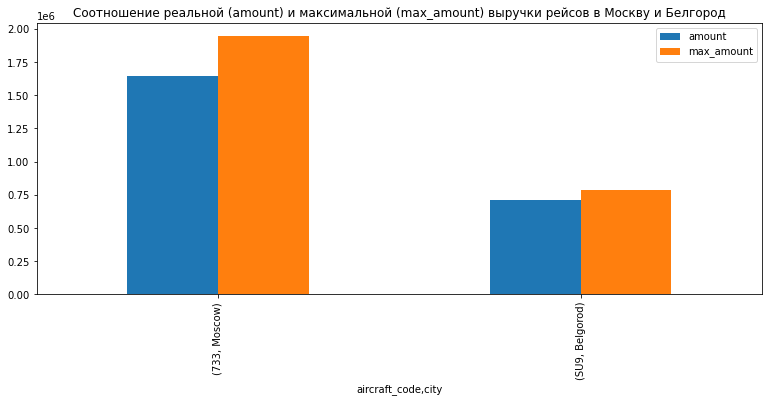

In [168]:
summary[['amount','max_amount']].plot(
                kind='bar', 
                title='Соотношение реальной (amount) и максимальной (max_amount) выручки рейсов в Москву и Белгород',
                )

##### Как видим, рейсы в Москву не только более чем в 2 раза прибыльней, но и запас по выручке по ним гораздо больше (16% против 10% т.е. при полной посадке на самолет возможна еще большая прибыль)